In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#После проведения EDA (блок ниже), написал функцию по предобработке данных для любого датафрейма, тест, трайн или фичи
#Сразу удаляем лишнюю колонку, преобразуем дату и переводи в int нужные признаки (например target и vas_id)
def prepare_data(data_df, columns_to_int=None):
    data_df['buy_time'] = pd.to_datetime(data_df['buy_time'], unit='s')
    try:
        data_df = data_df.drop(columns='Unnamed: 0')
    except KeyError:
        pass
    if columns_to_int:
        try:
            data_df[columns_to_int] = data_df[columns_to_int].astype('int64')
        except KeyError:
            print("Column doesn't exist, or isn't numeric type. Unable to convert type to int. Correct key mistakes, and try again")
    return data_df

### Загрузка и просмотр датасета

In [3]:
#Убираем фиктивные колонки, видимо индексы, преобразуем даты, чтобы увидеть больше информации из имеющихся данных
df_train = pd.read_csv('data_train.csv')
df_train = prepare_data(df_train, columns_to_int=['vas_id', 'target'])
df_test = pd.read_csv('data_test.csv')
df_test = prepare_data(df_test, columns_to_int='vas_id')
df_train

,id,vas_id,buy_time,target
0,540968,8,2018-09-16 21:00:00,0
1,1454121,4,2018-07-15 21:00:00,0
2,2458816,1,2018-08-12 21:00:00,0
3,3535012,5,2018-09-02 21:00:00,0
4,1693214,1,2018-09-02 21:00:00,0
...,...,...,...,...
831648,3812226,2,2018-12-30 21:00:00,0
831649,2480469,2,2018-12-30 21:00:00,0
831650,158236,2,2018-12-30 21:00:00,0
831651,1825525,2,2018-12-30 21:00:00,0


In [4]:
df_test

,id,vas_id,buy_time
0,3130519,2,2019-01-20 21:00:00
1,2000860,4,2019-01-20 21:00:00
2,1099444,2,2019-01-06 21:00:00
3,1343255,5,2019-01-13 21:00:00
4,1277040,2,2019-01-06 21:00:00
...,...,...,...
71226,2502453,5,2019-01-20 21:00:00
71227,1693213,2,2019-01-20 21:00:00
71228,1891350,2,2019-01-20 21:00:00
71229,2437172,2,2019-01-20 21:00:00


In [5]:
%%time
#Датафрейм очень большой, поэтому решил открывать пандасом только n-первых строк от него.
#UPD: Для максимального извлечения данных для обучения на мердж, прогружал 4250000 строк, почти весь датасет, больше в озу не умещается. Из этих данных намерджил 800000 объектов для обучения

df_features = pd.read_csv('features.csv.zip', sep='\t', engine='c', nrows=2250000)
df_features_half2 = pd.read_csv('features.csv.zip', sep='\t', engine='c', skiprows=[i for i in range(1, 2250000)])
#df_features = dd.read_csv('features.csv.zip', sep='\t')
df_features = prepare_data(df_features)
df_features_half2 = prepare_data(df_features_half2)
df_features

CPU times: total: 6min 44s
Wall time: 6min 45s


,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2013026,2018-07-15 21:00:00,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,2014722,2018-10-14 21:00:00,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,-53.216097,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2015199,2018-12-23 21:00:00,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,25.183903,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,2021765,2018-08-12 21:00:00,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,-65.076097,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,2027465,2018-08-05 21:00:00,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,-65.076097,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2249995,1910382,2018-09-23 21:00:00,-84.089971,91.410888,-98.030786,106.603202,-103.448246,85.49821,-16.08618,-59.146097,...,1980.626154,2251.229208,-22.996269,10.369552,-80.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
2249996,1910476,2018-12-09 21:00:00,-54.459971,-133.699112,-68.400786,-186.306798,-73.818246,-207.41179,-16.08618,-65.076097,...,-970.373846,-613.770792,-24.996269,-27.630448,-136.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2249997,1910755,2018-09-09 21:00:00,-92.559971,298.190888,96.029214,1120.953202,90.611754,1099.84821,-16.08618,-47.286097,...,-976.373846,-613.770792,-24.996269,-36.630448,-246.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
2249998,1910965,2018-09-30 21:00:00,-96.799971,-408.179112,-110.740786,-460.786798,-116.158246,-481.89179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


### 1. EDA (Explore Data Analysis)

In [6]:
df_features.describe()

,id,0,1,2,3,4,5,6,7,8,...,243,244,245,246,247,248,249,250,251,252
count,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,...,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06
mean,2.180632e+06,1.384095e-01,2.066754e-01,1.381051e-01,2.373670e-01,9.748741e-02,1.731523e-01,1.196795e-02,9.017393e-02,-3.833907e-02,...,-1.287198e+00,-7.467148e-01,1.003456e-01,-7.150350e-02,-7.049370e-01,-1.088263e-01,8.301778e-04,-8.262202e-03,1.043671e-03,2.555022e-01
std,1.260652e+06,1.946273e+02,4.071594e+02,2.097158e+02,4.791540e+02,2.263798e+02,5.422711e+02,1.078153e+02,2.737020e+02,7.412283e+01,...,3.200340e+03,2.236044e+03,1.062988e+03,2.959711e+02,1.329342e+03,2.518386e+02,1.661549e+01,1.748434e+02,8.229370e+00,8.337374e-01
min,3.000000e+00,-1.376470e+03,-1.494609e+03,-1.379881e+03,-1.331817e+03,-1.385638e+03,-2.009132e+03,-5.830362e+02,-8.023561e+02,-5.737337e+02,...,-9.773738e+02,-6.137708e+02,-2.599627e+01,-3.763045e+01,-3.067477e+02,-2.583289e+01,-6.944285e-01,-1.217593e+01,-4.561399e-01,0.000000e+00
25%,1.088280e+06,-9.679997e+01,-2.090291e+02,-1.107408e+02,-2.429968e+02,-1.161582e+02,-2.600218e+02,-1.608618e+01,-6.507610e+01,-6.783660e+00,...,-9.773738e+02,-6.137708e+02,-2.599627e+01,-3.763045e+01,-3.057477e+02,-2.583289e+01,-6.944285e-01,-1.217593e+01,-4.561399e-01,0.000000e+00
50%,2.178391e+06,-8.493997e+01,-6.071911e+01,-8.531079e+01,-7.942680e+01,-8.768825e+01,-9.353679e+01,-1.608618e+01,-6.507610e+01,-6.783660e+00,...,-9.583738e+02,-6.137708e+02,-2.599627e+01,-3.763045e+01,-2.397477e+02,-2.383289e+01,-6.944285e-01,-1.217593e+01,-4.561399e-01,0.000000e+00
75%,3.275414e+06,1.228003e+01,1.180909e+02,2.780921e+01,1.260832e+02,2.959175e+01,1.194582e+02,-1.608618e+01,-5.914610e+01,-6.783660e+00,...,-4.853738e+02,-4.077708e+02,-2.499627e+01,-3.363045e+01,-7.774772e+01,-1.083289e+01,-6.944285e-01,-9.175933e+00,-4.561399e-01,1.000000e+00
max,4.362734e+06,4.473950e+04,1.034994e+05,4.476064e+04,1.309629e+05,4.712013e+04,1.309418e+05,4.482021e+04,1.032552e+05,4.482952e+04,...,2.876716e+05,1.904692e+05,9.801580e+05,5.429037e+04,2.715813e+05,9.750017e+04,1.892331e+04,9.750782e+04,9.489544e+03,4.460000e+02


In [7]:
#Смотрим на число уникальный значений признака. Вероятно если одно значание - признак бесполезен, его можно выбросить
df_features.nunique().sort_values()

139          1
75           1
81           1
203          1
85           1
        ...   
117    1317474
207    1343057
38     1465830
116    1548854
id     2213001
Length: 255, dtype: int64

In [8]:
#Смотрю Null. Они отсутствуют везде, значит их не нужно обрабатывать
df_features.isna().sum()

id          0
buy_time    0
0           0
1           0
2           0
           ..
248         0
249         0
250         0
251         0
252         0
Length: 255, dtype: int64

In [9]:
df_train.isna().sum()

id          0
vas_id      0
buy_time    0
target      0
dtype: int64

In [10]:
df_test.isna().sum()

id          0
vas_id      0
buy_time    0
dtype: int64

In [11]:
#Смотрю даты
df_features['buy_time'].unique()

array(['2018-07-15T21:00:00.000000000', '2018-10-14T21:00:00.000000000',
       '2018-12-23T21:00:00.000000000', '2018-08-12T21:00:00.000000000',
       '2018-08-05T21:00:00.000000000', '2018-12-16T21:00:00.000000000',
       '2018-09-23T21:00:00.000000000', '2018-12-09T21:00:00.000000000',
       '2018-09-09T21:00:00.000000000', '2018-08-26T21:00:00.000000000',
       '2018-08-19T21:00:00.000000000', '2018-11-18T21:00:00.000000000',
       '2018-10-28T21:00:00.000000000', '2018-10-21T21:00:00.000000000',
       '2018-11-04T21:00:00.000000000', '2018-09-16T21:00:00.000000000',
       '2018-07-08T21:00:00.000000000', '2018-09-30T21:00:00.000000000',
       '2018-07-22T21:00:00.000000000', '2018-12-30T21:00:00.000000000',
       '2018-09-02T21:00:00.000000000', '2018-10-07T21:00:00.000000000',
       '2019-01-13T21:00:00.000000000', '2018-12-02T21:00:00.000000000',
       '2019-01-20T21:00:00.000000000', '2018-11-11T21:00:00.000000000',
       '2018-07-29T21:00:00.000000000', '2019-01-06

In [12]:
#Смотрю время теста, сортируя
test_time = sorted(df_test['buy_time'].unique())
test_time

[numpy.datetime64('2019-01-06T21:00:00.000000000'),
 numpy.datetime64('2019-01-13T21:00:00.000000000'),
 numpy.datetime64('2019-01-20T21:00:00.000000000')]

In [13]:
#Смотрю время трейна, сортируя
#Видно что на трейн, уходит 6 месяцев, а на тест один. Также видно что даты в трейн/тест и у фичей совершенно одинаковые. Это значит что можно мержить фичи в трейн/тест по паре id + дата, т.к пара id и дата полностью описывают параметры пользователей
train_time = sorted(df_train['buy_time'].unique())
train_time

[numpy.datetime64('2018-07-08T21:00:00.000000000'),
 numpy.datetime64('2018-07-15T21:00:00.000000000'),
 numpy.datetime64('2018-07-22T21:00:00.000000000'),
 numpy.datetime64('2018-07-29T21:00:00.000000000'),
 numpy.datetime64('2018-08-05T21:00:00.000000000'),
 numpy.datetime64('2018-08-12T21:00:00.000000000'),
 numpy.datetime64('2018-08-19T21:00:00.000000000'),
 numpy.datetime64('2018-08-26T21:00:00.000000000'),
 numpy.datetime64('2018-09-02T21:00:00.000000000'),
 numpy.datetime64('2018-09-09T21:00:00.000000000'),
 numpy.datetime64('2018-09-16T21:00:00.000000000'),
 numpy.datetime64('2018-09-23T21:00:00.000000000'),
 numpy.datetime64('2018-09-30T21:00:00.000000000'),
 numpy.datetime64('2018-10-07T21:00:00.000000000'),
 numpy.datetime64('2018-10-14T21:00:00.000000000'),
 numpy.datetime64('2018-10-21T21:00:00.000000000'),
 numpy.datetime64('2018-10-28T21:00:00.000000000'),
 numpy.datetime64('2018-11-04T21:00:00.000000000'),
 numpy.datetime64('2018-11-11T21:00:00.000000000'),
 numpy.datet

In [14]:
feature_time = sorted(df_features['buy_time'].unique())
feature_time

[numpy.datetime64('2018-07-08T21:00:00.000000000'),
 numpy.datetime64('2018-07-15T21:00:00.000000000'),
 numpy.datetime64('2018-07-22T21:00:00.000000000'),
 numpy.datetime64('2018-07-29T21:00:00.000000000'),
 numpy.datetime64('2018-08-05T21:00:00.000000000'),
 numpy.datetime64('2018-08-12T21:00:00.000000000'),
 numpy.datetime64('2018-08-19T21:00:00.000000000'),
 numpy.datetime64('2018-08-26T21:00:00.000000000'),
 numpy.datetime64('2018-09-02T21:00:00.000000000'),
 numpy.datetime64('2018-09-09T21:00:00.000000000'),
 numpy.datetime64('2018-09-16T21:00:00.000000000'),
 numpy.datetime64('2018-09-23T21:00:00.000000000'),
 numpy.datetime64('2018-09-30T21:00:00.000000000'),
 numpy.datetime64('2018-10-07T21:00:00.000000000'),
 numpy.datetime64('2018-10-14T21:00:00.000000000'),
 numpy.datetime64('2018-10-21T21:00:00.000000000'),
 numpy.datetime64('2018-10-28T21:00:00.000000000'),
 numpy.datetime64('2018-11-04T21:00:00.000000000'),
 numpy.datetime64('2018-11-11T21:00:00.000000000'),
 numpy.datet

In [15]:
df_train['vas_id'].unique()

array([8, 4, 1, 5, 2, 7, 6, 9], dtype=int64)

In [16]:
#Видно что услуг всего 9, их надо преобразовать в int
df_test['vas_id'].unique()

array([2, 4, 5, 6, 1, 7, 8, 9], dtype=int64)

In [17]:
#Просмотр баланса классов на тесте
feats_bar = df_train.drop(columns='target')
target = df_train['target']
feats_bar

,id,vas_id,buy_time
0,540968,8,2018-09-16 21:00:00
1,1454121,4,2018-07-15 21:00:00
2,2458816,1,2018-08-12 21:00:00
3,3535012,5,2018-09-02 21:00:00
4,1693214,1,2018-09-02 21:00:00
...,...,...,...
831648,3812226,2,2018-12-30 21:00:00
831649,2480469,2,2018-12-30 21:00:00
831650,158236,2,2018-12-30 21:00:00
831651,1825525,2,2018-12-30 21:00:00


In [18]:
target

0         0
1         0
2         0
3         0
4         0
         ..
831648    0
831649    0
831650    0
831651    0
831652    0
Name: target, Length: 831653, dtype: int64

0    0.927631
1    0.072369
Name: target, dtype: float64

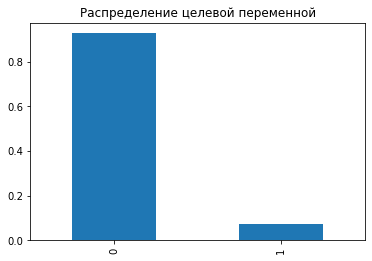

In [19]:
#Очень сильный дизбаланс классов. Возможно во время обучения нужно использовать деревья или мощные ансамбли (LightGBM или CatBoost?)
(target.value_counts()/target.shape[0]).plot(kind='bar', title='Распределение целевой переменной')
target.value_counts()/target.shape

In [20]:
%%time
#Исследвание фичей
features_copy = df_features.copy()
features_copy.set_index('id')
features_copy.drop(columns=['buy_time'], inplace=True)
feature_nunique = features_copy.apply(lambda x: x.nunique(dropna=False))
feature_nunique.shape

CPU times: total: 29.4 s
Wall time: 31.4 s


(254,)

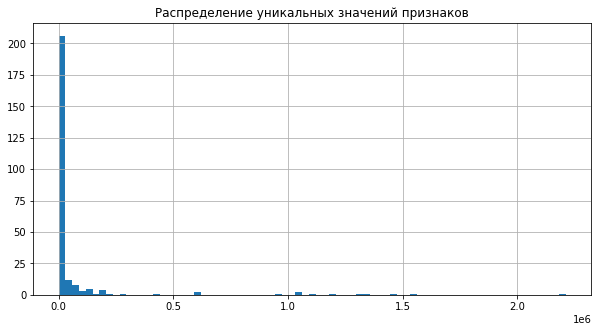

In [21]:
#Распределение значений
plt.title("Распределение уникальных значений признаков")
feature_nunique.hist(bins=75,figsize=(10, 5));

In [22]:
#Все признаки
f_all = set(feature_nunique.index.tolist())
len(f_all)

254

In [23]:
#Константные признаки, подлежат удалению (неиспользованию в обучении модели)
f_const = set(feature_nunique[feature_nunique == 1].index.tolist())
len(f_const)

5

In [24]:
f_const

{'139', '203', '75', '81', '85'}

In [25]:
%%time
#Вещественные признаки
f_numeric = (features_copy.fillna(0).astype(int).sum() - features_copy.fillna(0).sum()).abs()
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
len(f_numeric)

CPU times: total: 14.8 s
Wall time: 16.4 s


247

In [26]:
f_other = f_all - (f_numeric | f_const)
len(f_other)

2

In [27]:
#Остается 2 признака, id это понятно и 2ой скорее всего бинарный, посмотрим на него
f_other

{'252', 'id'}

In [28]:
#Видно что целочисленный, можно кидать в предобработку его на целое число, не категория определенно
features_copy['252'].nunique()

60

### Итоги EDA, выводы
1. Отсутствуют Null, id уникальны можно поставить индексом в датафреймах<br/>
2. Признаки с разными уникальными значениями, там где одно уникальное значение - их можно удалить, они не несут никакого смысла<br/>
3. Даты в фичах и в трейн/тест - одинаковые уникальные значения, это хорошо можно сразу мерджить фичи в трейн/тест данные по id + buy_time<br/>
4. Сильный дизбаланс классов, линейные модели вряд ли обучатся хорошо. Нужно использовать ансамбли или случайные леса скорее всего.<br/>
5. Target, vas_id нужно преобразовать в Int<br/>
6. Все признаки у которых уникальные значения в диапазоне от 2 до 30 считаем категориальными на старте<br/>
7. При попадании данных в пайплайн постараться делать сразу 3 действия: buy_time преобразовывать в date_time, делать drop 'Unnamed: 0', делать лефт мердж  по id и buy_time<br/>


UPD: Во второй ячейке написал функцию по первичной предобработке данных, по пункту 7 + сразу преобразовывает в инт указанные колонки<br/>
UPD2: Просмотрел фичи в датасете с фичами, теперь мерджить и писать пайплайны

### 2. Подготовка данных для обучения модели (Feature Engineering)

In [29]:
#Выбираем признаки для обучения
f_other.add('buy_time')
f_ok = list(f_other | f_numeric)
feats = df_features[f_ok]
feats

,97,79,51,187,13,25,148,2,168,110,...,55,140,226,95,116,106,45,61,118,136
0,-0.348913,-0.998268,52.911014,4.645192,49.520873,-2.082209,-0.317164,4.969214,-51.984826,-0.473446,...,38.254749,-1.276187,5.565998,-0.000115,-2844.828651,-9.408469,-16.642826,0.331838,-0.343415,3.277409
1,-0.348913,-0.998268,-8.088986,-16.354808,67.300873,131.407791,-0.317164,448.069214,-51.984826,-2.473446,...,1.254749,-1.276187,5.232666,-0.000115,-2940.989783,-9.408469,-65.059494,-0.408162,-0.343415,-2.722591
2,-0.348913,-0.998268,0.911014,6.645192,-66.189127,0.457791,-0.317164,-63.180786,12.548504,-2.473446,...,19.254749,-1.276187,-10.580668,-0.000115,11354.061013,-1.768469,-0.526164,-0.118162,-0.343415,-2.722591
3,-0.348913,-0.998268,-21.088986,-8.354808,37.620873,-2.082209,-0.317164,-6.930786,-51.984826,1.526554,...,-5.745251,-1.276187,-8.045113,-0.000115,-1386.298387,-9.408469,-32.309494,0.141838,-0.343415,6.277409
4,-0.348913,-0.998268,6.911014,-16.354808,-66.189127,-2.082209,-0.317164,-104.380786,-51.984826,-2.473446,...,15.254749,-1.276187,-4.350668,-0.000115,-2945.772987,-9.408469,-65.059494,-0.408162,-0.343415,-2.722591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2249995,-0.348913,-0.998268,13.911014,9.645192,-66.189127,-2.082209,-0.317164,-98.030786,11.298507,1.526554,...,2.254749,-1.276187,-4.792975,-0.000115,2676.237013,-9.408469,-1.776157,-0.048162,-0.343415,-2.722591
2249996,-0.348913,-0.998268,-39.088986,-16.354808,-54.359127,-2.082209,-0.317164,-68.400786,-51.984826,-2.473446,...,-9.745251,-1.276187,-7.913168,-0.000115,-2709.443867,-9.408469,-62.142828,0.311838,-0.343415,-0.722591
2249997,-0.348913,-0.998268,39.911014,19.645192,-66.189127,-2.082209,0.372836,96.029214,-51.984826,0.526554,...,0.254749,95.323813,-10.665885,-0.000115,419.431013,-9.408469,22.757176,-0.088162,-0.343415,20.277409
2249998,-0.348913,-0.998268,103.911014,-16.354808,-66.189127,-2.082209,-0.317164,-110.740786,-51.984826,-2.473446,...,-8.745251,-1.276187,-15.038168,-0.000115,-2945.754431,-9.408469,-65.059494,-0.408162,-0.343415,-2.722591


In [30]:
%%time
#Мерджим наш трейн с признаками по id. Даты получится 2 штуки, buy_time услуги и время сбора информации об абоненте. Также планирую добавить еще одну фичу, которая будет отвечать за разницу этого времени. Полагаю что чем значение больше ее будет, тем хуже, т.к информация об абоненте менее актуальна
train_feats_half1 = df_train.merge(feats, how='inner', on='id')
train_feats_half1

CPU times: total: 19.2 s
Wall time: 21.3 s


,id,vas_id,buy_time_x,target,97,79,51,187,13,25,...,55,140,226,95,116,106,45,61,118,136
0,3535012,5,2018-09-02 21:00:00,0,-0.348913,-0.998268,20.911014,13.645192,-9.829127,-2.082209,...,-1.745251,-1.276187,-11.137705,-0.000115,-2409.657757,14.721531,21.107170,0.061838,-0.343415,-2.722591
1,1693214,1,2018-09-02 21:00:00,0,-0.348913,-0.998268,31.911014,34.645192,-66.189127,-2.082209,...,-6.745251,-1.276187,-10.535450,-0.000115,-1475.845287,193.991531,143.573836,-0.128162,-0.343415,-2.722591
2,3173665,8,2018-07-29 21:00:00,0,-0.348913,-0.998268,-49.088986,-5.354808,-66.189127,-2.082209,...,-8.745251,-1.276187,-17.100668,-0.000115,-2945.772987,20.241531,-23.992828,0.081838,-0.343415,-2.722591
3,3577737,5,2018-12-23 21:00:00,0,-0.348913,-0.998268,31.911014,-4.354808,-66.189127,-2.082209,...,-8.745251,-1.276187,1.274332,-0.000115,-2379.139187,-9.408469,-16.426159,-0.108162,-0.343415,27.277409
4,2000856,1,2018-08-19 21:00:00,0,-0.348913,-0.998268,165.911014,78.645192,-66.189127,-2.082209,...,9.254749,81.743813,-13.125668,-0.000115,-1468.236887,25.761531,155.423846,0.221838,-0.343415,-2.722591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429311,2545695,5,2018-12-30 21:00:00,0,-0.348913,-0.998268,-23.088986,3.645192,-66.189127,-2.082209,...,14.254749,-1.276187,19.149332,-0.000115,-1580.319887,-9.408469,-43.876160,-0.058162,-0.343415,-2.722591
429312,3388613,5,2018-12-30 21:00:00,0,-0.348913,-0.998268,-41.088986,-13.354808,-66.189127,0.967791,...,-7.745251,-1.276187,-2.100668,-0.000115,13701.180013,-9.408469,-29.576160,-0.018162,-0.343415,-2.722591
429313,3897358,2,2018-12-30 21:00:00,0,-0.348913,-0.998268,-5.088986,-12.354808,-66.189127,-2.082209,...,-5.745251,-1.276187,-3.434001,-0.000115,-1635.495687,-9.408469,-64.676161,-0.128162,-0.343415,-2.722591
429314,2480469,2,2018-12-30 21:00:00,0,-0.348913,-0.998268,-12.088986,-15.354808,-66.189127,0.457791,...,-6.745251,-1.276187,-17.100668,-0.000115,3876.237713,-9.408469,-48.592829,-0.048162,-0.343415,10.277409


In [31]:
%%time
#Преобразование дат и просмотр датасета
train_feats_half1.rename(columns={'buy_time_x': 'buy_time', 'buy_time_y': 'data_recieve_time'}, inplace=True)
train_feats_half1[['id', 'vas_id', 'buy_time', 'data_recieve_time', 'target']]

CPU times: total: 0 ns
Wall time: 57.6 ms


,id,vas_id,buy_time,data_recieve_time,target
0,3535012,5,2018-09-02 21:00:00,2018-08-05 21:00:00,0
1,1693214,1,2018-09-02 21:00:00,2018-11-25 21:00:00,0
2,3173665,8,2018-07-29 21:00:00,2018-09-23 21:00:00,0
3,3577737,5,2018-12-23 21:00:00,2018-07-08 21:00:00,0
4,2000856,1,2018-08-19 21:00:00,2018-07-15 21:00:00,0
...,...,...,...,...,...
429311,2545695,5,2018-12-30 21:00:00,2018-07-22 21:00:00,0
429312,3388613,5,2018-12-30 21:00:00,2018-12-16 21:00:00,0
429313,3897358,2,2018-12-30 21:00:00,2018-12-09 21:00:00,0
429314,2480469,2,2018-12-30 21:00:00,2018-07-22 21:00:00,0


In [32]:
train_feats_half1

,id,vas_id,buy_time,target,97,79,51,187,13,25,...,55,140,226,95,116,106,45,61,118,136
0,3535012,5,2018-09-02 21:00:00,0,-0.348913,-0.998268,20.911014,13.645192,-9.829127,-2.082209,...,-1.745251,-1.276187,-11.137705,-0.000115,-2409.657757,14.721531,21.107170,0.061838,-0.343415,-2.722591
1,1693214,1,2018-09-02 21:00:00,0,-0.348913,-0.998268,31.911014,34.645192,-66.189127,-2.082209,...,-6.745251,-1.276187,-10.535450,-0.000115,-1475.845287,193.991531,143.573836,-0.128162,-0.343415,-2.722591
2,3173665,8,2018-07-29 21:00:00,0,-0.348913,-0.998268,-49.088986,-5.354808,-66.189127,-2.082209,...,-8.745251,-1.276187,-17.100668,-0.000115,-2945.772987,20.241531,-23.992828,0.081838,-0.343415,-2.722591
3,3577737,5,2018-12-23 21:00:00,0,-0.348913,-0.998268,31.911014,-4.354808,-66.189127,-2.082209,...,-8.745251,-1.276187,1.274332,-0.000115,-2379.139187,-9.408469,-16.426159,-0.108162,-0.343415,27.277409
4,2000856,1,2018-08-19 21:00:00,0,-0.348913,-0.998268,165.911014,78.645192,-66.189127,-2.082209,...,9.254749,81.743813,-13.125668,-0.000115,-1468.236887,25.761531,155.423846,0.221838,-0.343415,-2.722591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429311,2545695,5,2018-12-30 21:00:00,0,-0.348913,-0.998268,-23.088986,3.645192,-66.189127,-2.082209,...,14.254749,-1.276187,19.149332,-0.000115,-1580.319887,-9.408469,-43.876160,-0.058162,-0.343415,-2.722591
429312,3388613,5,2018-12-30 21:00:00,0,-0.348913,-0.998268,-41.088986,-13.354808,-66.189127,0.967791,...,-7.745251,-1.276187,-2.100668,-0.000115,13701.180013,-9.408469,-29.576160,-0.018162,-0.343415,-2.722591
429313,3897358,2,2018-12-30 21:00:00,0,-0.348913,-0.998268,-5.088986,-12.354808,-66.189127,-2.082209,...,-5.745251,-1.276187,-3.434001,-0.000115,-1635.495687,-9.408469,-64.676161,-0.128162,-0.343415,-2.722591
429314,2480469,2,2018-12-30 21:00:00,0,-0.348913,-0.998268,-12.088986,-15.354808,-66.189127,0.457791,...,-6.745251,-1.276187,-17.100668,-0.000115,3876.237713,-9.408469,-48.592829,-0.048162,-0.343415,10.277409


In [33]:
#Проверка что null отсутствуют. При left join, идут null по всем признакам, а значит эти данные абсолютно бесполезные. Поэтому делаем inner join
train_feats_half1['data_recieve_time'].isnull().sum()

0

In [34]:
#Указываем что признак 252, числовой. В будущем будет категория
train_feats_half1['252'] = train_feats_half1['252'].astype('int64')

In [35]:
#Сохранение полученных датасетов для обучения моделей
#train_feats.to_csv('4250k_feats_train.csv')

In [36]:
#Грузим датасет получившийся
#df_train_main = pd.read_csv('4250k_feats_train.zip', engine='c')
#df_train_main

CPU times: total: 0 ns
Wall time: 0 ns


In [37]:
%%time
feats_half2 = df_features_half2[f_ok]
train_feats_half2 = df_train.merge(feats_half2, how='inner', on='id')
train_feats_half2.rename(columns={'buy_time_x': 'buy_time', 'buy_time_y': 'data_recieve_time'}, inplace=True)
train_feats_half2

CPU times: total: 26.3 s
Wall time: 56.9 s


,id,vas_id,buy_time,target,97,79,51,187,13,25,...,55,140,226,95,116,106,45,61,118,136
0,540968,8,2018-09-16 21:00:00,0,-0.348913,-0.998268,-16.088986,-9.354808,-66.189127,-2.082209,...,-3.745251,-1.276187,-8.634002,-0.000115,236.454513,-9.408469,-36.759494,-0.108162,-0.343415,7.277409
1,1454121,4,2018-07-15 21:00:00,0,-0.348913,-0.998268,-34.088986,-16.354808,577.880873,-2.082209,...,-8.745251,-1.276187,3.327904,-0.000115,-2767.662617,-9.408469,-65.059494,-0.408162,-0.343415,-2.722591
2,2458816,1,2018-08-12 21:00:00,0,-0.348913,-0.998268,-24.088986,-8.354808,-66.189127,-2.082209,...,-7.745251,-1.276187,-6.314954,-0.000115,-2765.229037,-6.868469,-61.809494,-0.178162,-0.343415,-2.722591
3,2611143,2,2018-12-16 21:00:00,0,-0.348913,-0.998268,-51.088986,-16.354808,-66.189127,-2.082209,...,-9.745251,-1.276187,-17.100668,-0.000115,-2945.772987,-9.408469,-65.059494,-0.408162,-0.343415,-2.722591
4,2000856,1,2018-08-19 21:00:00,0,-0.348913,-0.998268,79.911014,49.645192,-66.189127,-2.082209,...,2.254749,69.883813,-13.148287,-0.000115,1070.842213,-9.408469,89.607176,0.081838,-0.343415,-2.722591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430731,1586693,2,2018-12-30 21:00:00,0,-0.348913,-0.998268,-45.088986,-11.354808,-66.189127,-2.082209,...,-6.745251,-1.276187,16.149332,-0.000115,-2945.190956,-9.408469,-63.192827,-0.028162,-0.343415,-2.722591
430732,90279,2,2018-12-30 21:00:00,0,-0.348913,-0.998268,-42.088986,-16.354808,-66.189127,-2.082209,...,-9.745251,-1.276187,23.649332,-0.000115,6977.692013,-9.408469,-65.059494,-0.408162,-0.343415,-2.722591
430733,3812226,2,2018-12-30 21:00:00,0,-0.348913,-0.998268,-39.088986,-7.354808,-66.189127,-2.082209,...,-4.745251,-1.276187,-1.900668,-0.000115,-2945.772987,115.011531,4.940506,-0.008162,-0.343415,-2.722591
430734,158236,2,2018-12-30 21:00:00,0,-0.348913,-0.998268,-51.088986,-16.354808,-66.189127,-2.082209,...,-9.745251,-1.276187,16.399332,-0.000115,1160.199713,-9.408469,-65.059494,-0.408162,-0.343415,-2.722591


In [38]:
#Объединяем маленький и большой датафрейм, чтобы извлечь 100% данных из полного файла, осталось создать фичу по датам и сохранить в файл
df_train_main = pd.concat([train_feats_half1, train_feats_half2], ignore_index=True)
df_train_main

,id,vas_id,buy_time,target,97,79,51,187,13,25,...,55,140,226,95,116,106,45,61,118,136
0,3535012,5,2018-09-02 21:00:00,0,-0.348913,-0.998268,20.911014,13.645192,-9.829127,-2.082209,...,-1.745251,-1.276187,-11.137705,-0.000115,-2409.657757,14.721531,21.107170,0.061838,-0.343415,-2.722591
1,1693214,1,2018-09-02 21:00:00,0,-0.348913,-0.998268,31.911014,34.645192,-66.189127,-2.082209,...,-6.745251,-1.276187,-10.535450,-0.000115,-1475.845287,193.991531,143.573836,-0.128162,-0.343415,-2.722591
2,3173665,8,2018-07-29 21:00:00,0,-0.348913,-0.998268,-49.088986,-5.354808,-66.189127,-2.082209,...,-8.745251,-1.276187,-17.100668,-0.000115,-2945.772987,20.241531,-23.992828,0.081838,-0.343415,-2.722591
3,3577737,5,2018-12-23 21:00:00,0,-0.348913,-0.998268,31.911014,-4.354808,-66.189127,-2.082209,...,-8.745251,-1.276187,1.274332,-0.000115,-2379.139187,-9.408469,-16.426159,-0.108162,-0.343415,27.277409
4,2000856,1,2018-08-19 21:00:00,0,-0.348913,-0.998268,165.911014,78.645192,-66.189127,-2.082209,...,9.254749,81.743813,-13.125668,-0.000115,-1468.236887,25.761531,155.423846,0.221838,-0.343415,-2.722591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860047,1586693,2,2018-12-30 21:00:00,0,-0.348913,-0.998268,-45.088986,-11.354808,-66.189127,-2.082209,...,-6.745251,-1.276187,16.149332,-0.000115,-2945.190956,-9.408469,-63.192827,-0.028162,-0.343415,-2.722591
860048,90279,2,2018-12-30 21:00:00,0,-0.348913,-0.998268,-42.088986,-16.354808,-66.189127,-2.082209,...,-9.745251,-1.276187,23.649332,-0.000115,6977.692013,-9.408469,-65.059494,-0.408162,-0.343415,-2.722591
860049,3812226,2,2018-12-30 21:00:00,0,-0.348913,-0.998268,-39.088986,-7.354808,-66.189127,-2.082209,...,-4.745251,-1.276187,-1.900668,-0.000115,-2945.772987,115.011531,4.940506,-0.008162,-0.343415,-2.722591
860050,158236,2,2018-12-30 21:00:00,0,-0.348913,-0.998268,-51.088986,-16.354808,-66.189127,-2.082209,...,-9.745251,-1.276187,16.399332,-0.000115,1160.199713,-9.408469,-65.059494,-0.408162,-0.343415,-2.722591


In [39]:
#Проверка что дубли не затесались нигде в строках
df_train_main.duplicated().sum()

0

In [40]:
#Добавляем фичу разницы дат с data_train и features, это будет разница дней предложения и сбора информации об абоненте.
df_train_main['time_delta(buy_time-recieve_time)'] = (pd.to_datetime(df_train_main['buy_time']) - pd.to_datetime(df_train_main['data_recieve_time'])).dt.days.astype('int64')
df_train_main

,id,vas_id,buy_time,target,97,79,51,187,13,25,...,140,226,95,116,106,45,61,118,136,time_delta(buy_time-recieve_time)
0,3535012,5,2018-09-02 21:00:00,0,-0.348913,-0.998268,20.911014,13.645192,-9.829127,-2.082209,...,-1.276187,-11.137705,-0.000115,-2409.657757,14.721531,21.107170,0.061838,-0.343415,-2.722591,28
1,1693214,1,2018-09-02 21:00:00,0,-0.348913,-0.998268,31.911014,34.645192,-66.189127,-2.082209,...,-1.276187,-10.535450,-0.000115,-1475.845287,193.991531,143.573836,-0.128162,-0.343415,-2.722591,-84
2,3173665,8,2018-07-29 21:00:00,0,-0.348913,-0.998268,-49.088986,-5.354808,-66.189127,-2.082209,...,-1.276187,-17.100668,-0.000115,-2945.772987,20.241531,-23.992828,0.081838,-0.343415,-2.722591,-56
3,3577737,5,2018-12-23 21:00:00,0,-0.348913,-0.998268,31.911014,-4.354808,-66.189127,-2.082209,...,-1.276187,1.274332,-0.000115,-2379.139187,-9.408469,-16.426159,-0.108162,-0.343415,27.277409,168
4,2000856,1,2018-08-19 21:00:00,0,-0.348913,-0.998268,165.911014,78.645192,-66.189127,-2.082209,...,81.743813,-13.125668,-0.000115,-1468.236887,25.761531,155.423846,0.221838,-0.343415,-2.722591,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860047,1586693,2,2018-12-30 21:00:00,0,-0.348913,-0.998268,-45.088986,-11.354808,-66.189127,-2.082209,...,-1.276187,16.149332,-0.000115,-2945.190956,-9.408469,-63.192827,-0.028162,-0.343415,-2.722591,28
860048,90279,2,2018-12-30 21:00:00,0,-0.348913,-0.998268,-42.088986,-16.354808,-66.189127,-2.082209,...,-1.276187,23.649332,-0.000115,6977.692013,-9.408469,-65.059494,-0.408162,-0.343415,-2.722591,-14
860049,3812226,2,2018-12-30 21:00:00,0,-0.348913,-0.998268,-39.088986,-7.354808,-66.189127,-2.082209,...,-1.276187,-1.900668,-0.000115,-2945.772987,115.011531,4.940506,-0.008162,-0.343415,-2.722591,154
860050,158236,2,2018-12-30 21:00:00,0,-0.348913,-0.998268,-51.088986,-16.354808,-66.189127,-2.082209,...,-1.276187,16.399332,-0.000115,1160.199713,-9.408469,-65.059494,-0.408162,-0.343415,-2.722591,84


In [41]:
#Сохраняем конечный сет для обучения модели, на нем можно сразу учить модель
#df_train_main.to_csv('train.csv')

In [42]:
%%time
#Грузим - проверяем что открывается корректно
df_train_main = pd.read_csv('train.zip', index_col='Unnamed: 0', parse_dates=['buy_time', 'data_recieve_time'])
df_train_main

CPU times: total: 56.9 s
Wall time: 1min


,id,vas_id,buy_time,target,130,118,119,66,21,211,...,128,155,230,175,204,196,105,228,244,time_delta(buy_time-recieve_time)
0,540968,8,2018-09-16 21:00:00,0,5.318359,-0.343415,-0.08972,-0.044465,54.495836,-61790.157098,...,0.104871,-0.000379,270.227508,-0.019198,0.039208,-0.251959,-0.040043,-33.302382,-613.770792,-56
1,1454121,4,2018-07-15 21:00:00,0,-14.681641,-0.343415,-0.08972,-0.044465,-10.744164,-61790.157098,...,-0.115129,-0.000379,-12.772492,-0.019198,0.039208,0.748041,-0.040043,-33.302382,-613.770792,7
2,2458816,1,2018-08-12 21:00:00,0,-5.681641,-0.343415,-0.08972,-0.044465,-10.744164,-61790.157098,...,0.414871,-0.000379,-39.772492,-0.019198,0.039208,0.748041,-0.040043,-33.302382,-613.770792,-105
3,3535012,5,2018-09-02 21:00:00,0,-7.681641,-0.343415,-0.08972,-0.044465,-10.744164,-61786.947098,...,0.324871,-0.000379,-38.772492,-0.019198,0.039208,-0.251959,-0.040043,-33.302382,-613.770792,28
4,1693214,1,2018-09-02 21:00:00,0,8.318359,-0.343415,-0.08972,-0.044465,-10.744164,-61771.833764,...,0.374871,-0.000379,9.227508,-0.019198,0.039208,0.748041,-0.040043,-33.302382,-612.770792,-84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860047,3897343,2,2018-12-30 21:00:00,0,0.318359,-0.343415,-0.08972,-0.044465,-10.744164,-61790.157098,...,-0.575129,-0.000379,-39.772492,-0.019198,0.039208,-0.251959,-0.040043,-33.302382,-613.770792,161
860048,1498639,5,2018-12-30 21:00:00,0,15.318359,-0.343415,-0.08972,-0.044465,-10.744164,-59692.087098,...,-0.575129,-0.000379,-39.772492,-0.019198,0.039208,-0.251959,-0.040043,-33.302382,-613.770792,-7
860049,1715328,2,2018-12-30 21:00:00,0,12.318359,42.805023,-0.08972,-0.044465,157.055836,-61790.157098,...,0.244871,-0.000379,28.227508,1.980802,0.039208,0.748041,-0.040043,-33.302382,-302.770792,154
860050,3087053,5,2018-12-30 21:00:00,0,-3.681641,-0.343415,-0.08972,-0.044465,-10.744164,-61790.157098,...,0.354871,-0.000379,-39.772492,-0.019198,0.039208,-0.251959,-0.040043,-33.302382,-613.770792,7


In [60]:
#Попробую замерджить данные из нашего большого трейна в тест, по id и buy_time и смотреть разницу в числе строк, датасета. Количество строк не должно меняться
df_test

,id,vas_id,buy_time
0,3130519,2,2019-01-20 21:00:00
1,2000860,4,2019-01-20 21:00:00
2,1099444,2,2019-01-06 21:00:00
3,1343255,5,2019-01-13 21:00:00
4,1277040,2,2019-01-06 21:00:00
...,...,...,...
71226,2502453,5,2019-01-20 21:00:00
71227,1693213,2,2019-01-20 21:00:00
71228,1891350,2,2019-01-20 21:00:00
71229,2437172,2,2019-01-20 21:00:00


In [44]:
feats.columns.to_list()

['97',
 '79',
 '51',
 '187',
 '13',
 '25',
 '148',
 '2',
 '168',
 '110',
 '23',
 '98',
 '102',
 '0',
 '185',
 '217',
 '101',
 '5',
 '46',
 '141',
 '224',
 '241',
 '138',
 '158',
 '31',
 '17',
 '33',
 '77',
 '153',
 '78',
 '54',
 '89',
 '227',
 '181',
 '90',
 '59',
 '103',
 '231',
 '44',
 '29',
 '193',
 '125',
 '27',
 '47',
 '163',
 '151',
 '208',
 '107',
 '164',
 '149',
 '223',
 '171',
 '133',
 '237',
 '64',
 '100',
 '220',
 '244',
 '87',
 '69',
 '166',
 '172',
 '232',
 '186',
 '209',
 '184',
 '3',
 '165',
 '126',
 '48',
 '108',
 '146',
 '155',
 '175',
 '191',
 '180',
 '249',
 '36',
 '206',
 '42',
 '57',
 '131',
 '201',
 '65',
 '34',
 '247',
 '156',
 '137',
 '22',
 '154',
 '179',
 '169',
 '145',
 'id',
 '15',
 '252',
 '212',
 '52',
 '207',
 '221',
 '91',
 '1',
 '111',
 '170',
 '73',
 '189',
 '12',
 '230',
 '216',
 '88',
 '229',
 '200',
 '117',
 '14',
 '53',
 '157',
 '235',
 '243',
 '198',
 '192',
 '178',
 '228',
 '40',
 '215',
 '16',
 '104',
 '38',
 '242',
 '121',
 '205',
 '114',
 '196

In [45]:
feats_half2.columns.to_list()
feats_half2.columns.to_list() == feats.columns.to_list()

True

In [46]:
test_h1 = df_test.merge(feats, how='inner', on='id')
test_h1.rename(columns={'buy_time_x': 'buy_time', 'buy_time_y': 'data_recieve_time'}, inplace=True)
test_h1

,id,vas_id,buy_time,97,79,51,187,13,25,148,...,55,140,226,95,116,106,45,61,118,136
0,3130519,2,2019-01-20 21:00:00,-0.348913,-0.998268,-22.088986,-0.354808,-66.189127,-2.082209,-0.317164,...,-8.745251,-1.276187,6.899332,-0.000115,-2850.687047,-9.408469,-53.726160,0.421838,-0.343415,-2.722591
1,2000860,4,2019-01-20 21:00:00,-0.348913,-0.998268,-9.088986,-16.354808,-66.189127,-2.082209,-0.317164,...,-9.745251,-1.276187,1.399332,-0.000115,-2944.810091,-9.408469,-65.059494,-0.408162,-0.343415,-2.722591
2,1343255,5,2019-01-13 21:00:00,-0.348913,-0.998268,-22.088986,-7.354808,289.740873,-2.082209,0.182836,...,-9.745251,-1.276187,-7.475668,-0.000115,-2945.772987,-9.408469,-2.209494,-0.058162,-0.343415,-2.722591
3,3195325,6,2019-01-20 21:00:00,-0.348913,-0.998268,-35.088986,-16.354808,-66.189127,-2.082209,-0.317164,...,-9.745251,-1.276187,-8.850668,-0.000115,-2945.377476,-9.408469,-65.059494,-0.408162,-0.343415,-2.722591
4,3324464,1,2019-01-13 21:00:00,-0.348913,-0.998268,22.911014,-15.354808,-66.189127,-2.082209,0.282836,...,47.254749,-1.276187,0.613617,-0.000115,-2451.505407,-9.408469,-37.809496,0.261838,-0.343415,1.277409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36811,4151123,2,2019-01-20 21:00:00,-0.348913,-0.998268,32.911014,43.645192,-66.189127,-2.082209,-0.317164,...,37.254749,-1.276187,3.299332,-0.000115,1640.399013,-9.408469,8.190506,-0.138162,-0.343415,-2.722591
36812,3474537,2,2019-01-20 21:00:00,-0.348913,-0.998268,-40.088986,-16.354808,-66.189127,-2.082209,-0.317164,...,-0.745251,-1.276187,12.899332,-0.000115,-2896.436073,-9.408469,-65.059494,-0.408162,-0.343415,-2.722591
36813,2502453,5,2019-01-20 21:00:00,-0.348913,-0.998268,-51.088986,-16.354808,-66.189127,-2.082209,-0.317164,...,-9.745251,-1.276187,7.099332,-0.000115,-2945.772987,-9.408469,-65.059494,-0.408162,-0.343415,-2.722591
36814,2437172,2,2019-01-20 21:00:00,-0.348913,-0.998268,-40.088986,-16.354808,145.670873,-2.082209,-0.317164,...,-7.745251,-1.276187,-2.100668,-0.000115,-2850.338417,-9.408469,-65.059494,-0.408162,-0.343415,-2.722591


In [47]:
test_h2 = df_test.merge(feats_half2, how='inner', on='id')
test_h2.rename(columns={'buy_time_x': 'buy_time', 'buy_time_y': 'data_recieve_time'}, inplace=True)
test_h2

,id,vas_id,buy_time,97,79,51,187,13,25,148,...,55,140,226,95,116,106,45,61,118,136
0,1099444,2,2019-01-06 21:00:00,-0.348913,-0.998268,51.911014,-16.354808,-66.189127,-2.082209,-0.317164,...,-4.745251,-1.276187,-6.100668,-0.000115,-2945.772987,3.301531,-64.476161,-0.038162,-0.343415,-2.722591
1,1277040,2,2019-01-06 21:00:00,-0.348913,-0.998268,-33.088986,-15.354808,357.540873,-2.082209,-0.317164,...,-4.745251,-1.276187,11.699332,-0.000115,305.159613,-9.408469,-64.659494,-0.218162,-0.343415,-2.722591
2,720364,2,2019-01-13 21:00:00,-0.348913,-0.998268,-37.088986,-16.354808,-66.189127,2.667791,-0.317164,...,-9.745251,-1.276187,14.399332,-0.000115,-2754.278827,-9.408469,-65.059494,-0.408162,-0.343415,-2.722591
3,4088271,2,2019-01-13 21:00:00,-0.348913,-0.998268,-2.088986,14.645192,145.670873,-2.082209,-0.317164,...,-9.745251,-1.276187,-9.942773,-0.000115,803.543413,-9.408469,-38.476160,0.061838,-0.343415,-2.722591
4,921310,5,2019-01-06 21:00:00,-0.348913,-0.998268,-41.088986,-7.354808,52.840873,87.967791,0.182836,...,-8.745251,-1.276187,5.732666,-0.000115,-2945.772987,-9.408469,-16.092827,-0.148162,-0.343415,-2.722591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36845,899101,2,2019-01-20 21:00:00,-0.348913,-0.998268,-47.088986,-16.354808,-66.189127,-2.082209,-0.317164,...,-9.745251,-1.276187,18.149332,-0.000115,-296.179187,-9.408469,-65.059494,-0.408162,-0.343415,-2.722591
36846,3173663,2,2019-01-20 21:00:00,-0.348913,-0.998268,-32.088986,-13.354808,-66.189127,-2.082209,0.182836,...,-6.745251,-1.276187,4.899332,-0.000115,-2724.880407,-7.878469,-59.276160,0.111838,-0.343415,-2.722591
36847,2545712,2,2019-01-20 21:00:00,-0.348913,-0.998268,7.911014,12.645192,137.200873,-2.082209,0.402836,...,18.254749,-1.276187,5.042189,-0.000115,-2883.844277,20.251531,31.707176,0.051838,-0.343415,-2.722591
36848,1693213,2,2019-01-20 21:00:00,-0.348913,-0.998268,-51.088986,-9.354808,-66.189127,-2.082209,-0.317164,...,-9.745251,-1.276187,21.232664,-0.000115,-2945.772987,-9.408469,-47.242826,0.541838,-0.343415,-0.722591


In [ ]:
df_test_mod = pd.concat([test_h1, test_h2], ignore_index=True)
df_test_mod

In [93]:
#Удалем все дубликаты в датасете с признаками и получаем исходную размерность тестового датасета, значит во время обработки необходимо выполнить все эти приемы
df_test_mod = df_test_mod[~df_test_mod[['id', 'vas_id', 'buy_time']].duplicated()]
df_test_mod[['buy_time', 'data_recieve_time']]

,buy_time,data_recieve_time
0,2019-01-20 21:00:00,2018-09-09 21:00:00
1,2019-01-20 21:00:00,2018-07-22 21:00:00
2,2019-01-13 21:00:00,2018-09-09 21:00:00
3,2019-01-20 21:00:00,2019-01-13 21:00:00
4,2019-01-13 21:00:00,2018-07-15 21:00:00
...,...,...
73661,2019-01-20 21:00:00,2018-08-26 21:00:00
73662,2019-01-20 21:00:00,2018-12-23 21:00:00
73663,2019-01-20 21:00:00,2018-08-12 21:00:00
73664,2019-01-20 21:00:00,2018-11-11 21:00:00


### Итоги 2го этапа.
1) Написал функцию по предобработке исходных данных. (Удаление колнки лишней, float_to_int, преобразование из timestamp в datetime)
2) Подготовил из 4250000 объектов с признаками (94.5% всех признаков), ~800000 для обучения модели через мердж трейна и признаков по пользователям
3) Получили 2 даты по каждому пользователю: одна - дата покупки, вторая - дата сбора информации об абоненте. Необходимо будет сделать 3ю фичу разницу этих дат в днях по модулю, она будет отражать актуальность данных об абоненте

###### Дальнейший план работы
1) Загрузить данные из заготовленного файла для трейна 4250k_feats_train.zip в нем csv
2) Перед созданием последней фичи или после, промерджить данные по id/id+buy_time, в data_train.csv. Необходимо убедиться что тест, никак не меняется по объему данных (количеству объектов или хотя бы в не меньшую сторону)
3) Разбить данные на трейн/тест, для измерения метрики. Кросс валидация по ситуации буду думать и по времени, наверное после бейзлайна уже.
4) После создания фичи, можно собирать модель/пайплайн и обучать модель. Затем gridsearch/другие модели, но исходные данные будут уже эти точно
5) Сохранение результатов и все остальные прикладные вещи

UPD: Добавил данные в пункт 2 итогов, до полного количества, собрал 100% данных и добавил фичу разницы дней.
UPD2: Фичи собираю через 2 датафрейма из features.csv, а потом при предсказания теста, нужно делать конкатенацию, чтобы вернуть исходное состояние. В полученном датасете больше строк чем в тесте, т.к id дублируются для разного времени.
UPD3: Решено UPD2, df_test_mod[~df_test_mod[['id', 'vas_id', 'buy_time']].duplicated()], удаляем дубликаты подмножества (id, vas_id, buy_time), получаем исходный датасет. Очень важно при обработке

In [49]:
"""
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)
"""

'\nclass ColumnSelector(BaseEstimator, TransformerMixin):\n    def __init__(self, columns):\n        self.columns = columns\n\n    def fit(self, X, y=None):\n        return self\n\n    def transform(self, X):\n        assert isinstance(X, pd.DataFrame)\n\n        try:\n            return X[self.columns]\n        except KeyError:\n            cols_error = list(set(self.columns) - set(X.columns))\n            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)\n'